In [2]:
from access import Access, weights, Datasets

import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
Datasets.available_datasets()


chi_times: Cost matrix with travel times from each Chicago Census Tract to all others.

chi_doc: Doctor and dentist counts for each Chicago Census Tract.

chi_pop: Population counts for each Chicago Census Tract.

chi_doc_geom: Doctor and dentist counts for each Chicago Census Tract along with geometric representations for Census Tracts.

chi_pop_geom: Population counts for each Chicago Census Tract along with geometric representations for Census Tracts.

chi_euclidean: Euclidean distance cost matrix with distances from each demand Chicago Census Tract to all others.

chi_euclidean_neighbors: Euclidean distance cost matrix with distances from each supply Census Tract to all others.

cook_county_hospitals: Contains data for each hospital location in Cook County including X Y coordinates.

cook_county_hospitals_geom: Contains data for each hospital location in Cook County including X Y coordinates, and geometric points for each hospital.

cook_county_tracts: Geometric representation of 

# Cargamos oferta y demanda

Cada geoid es el identificador de un census tract. Las geometrías son los centroides de los tracts

In [4]:
chi_pop   = Datasets.load_data('chi_pop_geom')
chi_doc   = Datasets.load_data('chi_doc_geom')

Creating directory chi_med_data...
Download complete.
Download complete.


In [5]:
chi_pop.head()

,geoid,pop,geometry
0,17031010100,4854,POINT (354916.992 594670.505)
1,17031010201,6450,POINT (354105.876 594088.600)
2,17031010202,2818,POINT (354650.684 594093.822)
3,17031010300,6236,POINT (355209.361 594086.149)
4,17031010400,5042,POINT (355809.748 592808.043)


<AxesSubplot:>

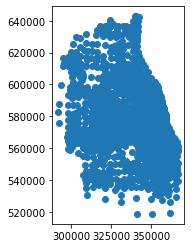

In [6]:
chi_pop.plot()

# Cargamos tiempos de viaje

Un modelo de cosato entre los geoids de origen y destino. En este caso el costo es tiempo en minutos, pero aparentemente podría ser cualquier cosa

In [7]:
chi_times = Datasets.load_data('chi_times')
chi_times.head()

Download complete.


,origin,dest,cost
0,17093890101,17031010100,91.20
1,17093890101,17031010201,92.82
2,17093890101,17031010202,92.95
3,17093890101,17031010300,89.40
4,17093890101,17031010400,84.97


# Creamos el objeto `acces`

In [8]:
A = Access(demand_df            = chi_pop,
           demand_index         = 'geoid',
           demand_value         = 'pop',
           supply_df            = chi_doc,
           supply_index         = 'geoid',
           supply_value         = ['doc','dentist'],
           cost_df              = chi_times,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'cost',
           neighbor_cost_df     = chi_times,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'cost')

## Otra medida de distancia

Agregamos la distancia euclidiana

In [9]:
print(A.demand_df.crs)
print(A.supply_df.crs)

epsg:2790
epsg:2790


In [10]:
A.demand_df = A.demand_df.to_crs(epsg = 3528)
A.supply_df = A.supply_df.to_crs(epsg = 3528)

In [11]:
A.create_euclidean_distance(threshold = 250000, centroid_o = True, centroid_d = True)

In [12]:
A.cost_df

,origin,dest,cost,euclidean
0,17093890101,17031010100,91.20,63630.788476
1,17093890101,17031010201,92.82,62632.675522
2,17093890101,17031010202,92.95,63073.735631
3,17093890101,17031010300,89.40,63520.029749
4,17093890101,17031010400,84.97,63268.514352
...,...,...,...,...
4284625,17197980100,17111870809,NaN,80097.128392
4284626,17197980100,17111871310,NaN,67358.028756
4284627,17197980100,17197880308,NaN,11161.067033
4284628,17197980100,17197881007,NaN,14547.843032


## Funciones de peso

Esto tengo que entenderlo mejor

In [13]:
# stepwise weight dictionaries
fn30 = weights.step_fn({10 : 1, 20 : 0.68, 30 : 0.22})
fn60 = weights.step_fn({20 : 1, 40 : 0.68, 60 : 0.22})
# gaussian 20 minutes mean
gaussian = weights.gaussian(20)
# gravity catchement pesado por gravedad
gravity = weights.gravity(scale = 60, alpha = -1)

# Calculamos la accesibilidad

Vamos a usar todos los modelos disponibles. Para el `enhanced_two_stage_fca` usaremos las funciones de costo del paso anterior

In [14]:
A.weighted_catchment    (name = "gravity",  weight_fn = gravity)
A.fca_ratio             (name = "fca",      max_cost = 15)
A.fca_ratio             (name = "fca30",    max_cost = 30) 
A.fca_ratio             (name = "fca60",    max_cost = 60)
A.fca_ratio             (name = "fca90",    max_cost = 90)
A.two_stage_fca         (name = "2sfca",    max_cost = 60)
A.enhanced_two_stage_fca(name = "2sfca30",  weight_fn = fn30)
A.enhanced_two_stage_fca(name = "2sfca60",  weight_fn = fn60)
A.enhanced_two_stage_fca(name = "g2sfca",   weight_fn = gaussian)
A.three_stage_fca       (name = "3sfca")

A.raam(name = "raam", tau = 60); # tau es el umbral de costo, 60 minutos
A.raam(name = "raam30", tau = 30);

access INFO     :: Using default cost, cost, for gravity.
access INFO     :: Using default cost, cost, for fca.
access INFO     :: Using default neighbor cost, cost, for fca.
access INFO     :: Using default cost, cost, for fca30.
access INFO     :: Using default neighbor cost, cost, for fca30.
access INFO     :: Using default cost, cost, for fca60.
access INFO     :: Using default neighbor cost, cost, for fca60.
access INFO     :: Using default cost, cost, for fca90.
access INFO     :: Using default neighbor cost, cost, for fca90.
access INFO     :: Using default cost, cost, for 2sfca.
access INFO     :: Using default cost, cost, for 2sfca30.
access INFO     :: Using default cost, cost, for 2sfca60.
access INFO     :: Using default cost, cost, for g2sfca.
access INFO     :: Using default cost, cost, for 3sfca.
access INFO     :: Using default cost, cost, for raam.
access INFO     :: Using default cost, cost, for raam30.


Vemos el resultado, los valores quedan en el dataframe acces_df de nuestro objeto de accesibilidad

In [15]:
A.access_df.sort_values(by='raam_doc').dropna().head()

,pop,gravity_doc,gravity_dentist,fca_doc,fca_dentist,fca30_doc,fca30_dentist,fca60_doc,fca60_dentist,fca90_doc,...,2sfca60_doc,2sfca60_dentist,g2sfca_doc,g2sfca_dentist,3sfca_doc,3sfca_dentist,raam_doc,raam_dentist,raam30_doc,raam30_dentist
geoid,,,,,,,,,,,,,,,,,,,,,
17031808800,3955,48874.111283,7990.336879,0.002070,0.000846,0.001049,0.000878,0.001100,0.000667,0.000912,...,0.000650,0.000431,0.000700,0.000433,0.001666,0.000963,0.610053,0.842621,0.518374,0.869783
17031809300,4816,14613.314584,6731.779891,0.001788,0.000788,0.001082,0.000821,0.001174,0.000694,0.000925,...,0.000635,0.000401,0.000683,0.000415,0.001695,0.000965,0.654022,0.897259,0.605593,0.961986
17031806801,4225,17700.521096,10206.437126,0.001518,0.000958,0.001036,0.000936,0.000988,0.000650,0.000901,...,0.001029,0.000678,0.001045,0.000704,0.001378,0.001067,0.676216,0.751016,0.588885,0.615765
17031809100,3387,10512.460373,6840.560712,0.002156,0.000874,0.001109,0.000886,0.001059,0.000664,0.000906,...,0.000805,0.000515,0.000829,0.000528,0.001654,0.000950,0.701590,0.893923,0.690675,0.924893
17031808702,5504,23763.514763,8244.668327,0.001626,0.000623,0.001106,0.000779,0.001179,0.000691,0.000928,...,0.000626,0.000387,0.000645,0.000383,0.001687,0.000912,0.703447,0.932076,0.686627,0.956822


También podemos usar la distancia euclidiana para calcular la accesibilidad. Aquí lo hacemos para RAAM. Tenemos que usar un umbral diferente, ahora las unidades son metros.

In [16]:
raam = A.raam(name = "raam_euclidean", tau = 1e5, cost = "euclidean")
raam.head()

,raam_euclidean_doc,raam_euclidean_dentist
geoid,,
17031010100,0.837117,0.881353
17031010201,0.836282,0.899506
17031010202,0.842233,0.878215
17031010300,0.859648,0.891032
17031010400,0.893507,0.883204


Hasta aquí tenemos un montón de medidas de accesibilidad, podemos combianr (suma pesada) algunas para obtener un score

In [17]:
A.score(name = "raam_combo", col_dict = {"raam_doc" : 0.8, "raam_dentist" : 0.2})

geoid
17031010100    0.760373
17031010201    0.751101
17031010202    0.782341
17031010300    0.825140
17031010400    0.913720
                 ...   
17197883903    1.485736
17197883904    1.392151
17197884101    1.402404
17197884103    1.388448
17197980100    1.381479
Name: raam_combo, Length: 1930, dtype: float64

# Mapas

In [18]:
il_map = chi_doc.set_index('geoid')[["geometry"]].join(A.norm_access_df, how = "inner")

def plot(v, ax = None, leg = True):
    
    swap_colors = "raam" in v
    
    il_map.plot(v, legend = leg, figsize = (5, 5), 
                cmap = "viridis_r" if swap_colors else "viridis", 
                markersize = 5, alpha = 0.8, ax = ax,
                vmin = il_map[v].quantile(0.05), vmax = il_map[v].quantile(0.95)).set_axis_off()

## RAAM

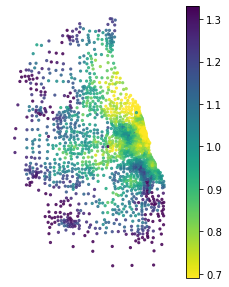

In [19]:
plot("raam_doc")

## 3-Stage Floating Catchment Areas

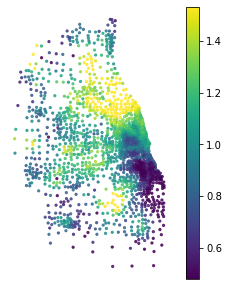

In [20]:
plot("3sfca_dentist")

## RAAM doctores, dentistas, ambos

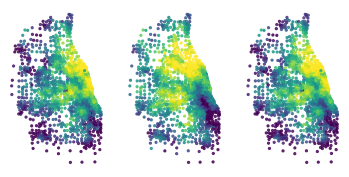

In [21]:
fig, ax = plt.subplots(1, 3, subplot_kw = {"aspect" : "equal"})
for axi in ax: axi.set_axis_off()

plot("raam_doc",     ax = ax[0], leg = False)
plot("raam_dentist", ax = ax[1], leg = False)
plot("raam_combo",   ax = ax[2], leg = False)